## Inspect the results for different model choices of the DenseNet architecture for the bearings dataset

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pplot
import os
import json

In [28]:

!ls Bearings-experiments/Bearing_dataset_model_selection/DenseNet_bearings_ndn4_nf3_dilrates[1,\ 4,\ 8,\ 16,\ 32,\ 64,\ 128,\ 256,\ 512,\ 8,\ 16,\ 32,\ 64,\ 128,\ 512]_closs0.01

checkpoint	   fit_epoch_019.png  fit_epoch_041.png
diagn_figure.png   fit_epoch_021.png  fit_epoch_043.png
fit_epoch_001.png  fit_epoch_023.png  fit_epoch_045.png
fit_epoch_003.png  fit_epoch_025.png  fit_epoch_047.png
fit_epoch_005.png  fit_epoch_027.png  fit_epoch_049.png
fit_epoch_007.png  fit_epoch_029.png  losses_dataframe.pkl
fit_epoch_009.png  fit_epoch_031.png  model.data-00000-of-00002
fit_epoch_011.png  fit_epoch_033.png  model.data-00001-of-00002
fit_epoch_013.png  fit_epoch_035.png  model.index
fit_epoch_015.png  fit_epoch_037.png  model_json.json
fit_epoch_017.png  fit_epoch_039.png


In [81]:

def load_bearings_dataset(all_files):
    fnames = all_files
    exp_ids_tot = [];
    yrem_tot = [];
    sensor_values_tot = []

    for kk,fname in enumerate(fnames):
        p1 = pd.read_pickle("bearing_fatigue_dataset/%s"%fname)
        p1['abs_timestamp'] = (p1['h']*60+p1['m'])*60+p1['s']+p1['se-6']/1e6
        sensors = p1.groupby("block").apply(lambda x : [x['abs_timestamp'].mean(),np.vstack([x['h_acc'].values, x['v_acc'].values]).T])
        sens_val = np.dstack([v[1] for v in sensors.values])
        sensor_values = np.swapaxes(np.swapaxes(sens_val,0,-1),1,2).astype('float32')
        #print(sensor_values.shape)
        
        yrem = np.vstack([v[0] for v in sensors.values]).astype('float32')
        yrem = np.abs(yrem - np.max(yrem))

        exp_id = np.hstack([kk for v in range(yrem.shape[0])])

        sensor_values_tot.append(sensor_values)
        exp_ids_tot.append(exp_id);
        yrem_tot.append(yrem)

        print(kk)

    yrem_tot = np.vstack(yrem_tot).flatten()
    eid = np.hstack(exp_ids_tot).flatten()
    X = np.vstack(sensor_values_tot)
    return yrem_tot, eid, X
# Loading data:
all_files = [f for f in os.listdir(os.path.join('bearing_fatigue_dataset')) if 'pickle' in f]
yrem_s_raw, eid, X = load_bearings_dataset(all_files = all_files)

(172, 2559, 2)
0
(1502, 2559, 2)
1
(1637, 2559, 2)
2
(515, 2559, 2)
3
(871, 2559, 2)
4
(1802, 2559, 2)
5
(2302, 2559, 2)
6
(1202, 2559, 2)
7
(1139, 2559, 2)
8
(2002, 2559, 2)
9
(572, 2559, 2)
10
(352, 2559, 2)
11
(797, 2559, 2)
12
(911, 2559, 2)
13
(612, 2559, 2)
14
(2803, 2559, 2)
15
(2302, 2559, 2)
16


In [82]:
yrem = [];

# some basic preproc
for ee in np.unique(eid):
    yelapsed_ = np.cumsum(yrem_s_raw[eid == ee])
    yrem_ = np.max(yelapsed_) - yelapsed_;
    yrem.append(yrem_)
yrem = np.hstack(yrem)

eid_oh = np.zeros([eid.shape[0],np.max(eid) + 1])
for k in np.unique(eid):
    eid_oh[eid == k,k] = 1.;

yrem_norm = yrem / np.std(yrem);


## Defining the "source" and "target" domains:
conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
inds_data_source =  [4,6,8,15,  9,10,0,7,  2,11]

conds_flag_target = [0,0,0,   1, 1, 1,  2]
inds_data_target  = [1,5,16,  12,13,14,  3]

# for the moment I do not try to adapt domains with info pertaining to the loading conditions.
X_source_experiments = X[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_data_source]]
yrem_norm_source     = yrem_norm[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_data_source]]
eid_oh_source        = eid_oh[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_data_source]]

X_target_experiments = X[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_data_target]]
yrem_norm_target     = yrem_norm[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_data_target]]
eid_oh_target        = eid_oh[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_data_target]]

In [34]:
# Make a large dataset built with columns corresponding to the model json differences:
root_f = os.path.join("Bearings-experiments","Bearing_dataset_model_selection")

all_data = []
for f in [f_ for f_ in os.listdir(root_f) if 'DenseNet_' in f_]:
    if (len(os.listdir(os.path.join(root_f, f)))) > 0:
        with open(os.path.join(root_f, f, "model_json.json") ,'r') as ff: 
            jfile = json.load(ff)
            
        all_data.append((jfile, pd.read_pickle(os.path.join(root_f,f,"losses_dataframe.pkl"))))
        

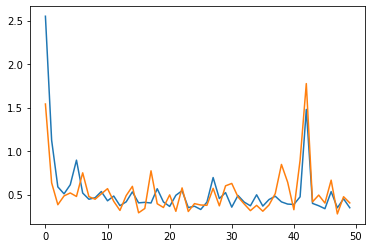

In [42]:
pplot.plot(all_data[0][1]['loss'])
pplot.plot(all_data[0][1]['val_loss'])


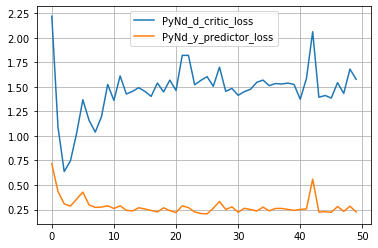

In [49]:
dd = all_data[0][1]
pplot.plot(dd['PyNd_d_critic_loss'].values, label ='PyNd_d_critic_loss' )
pplot.plot(dd['PyNd_y_predictor_loss'],label = 'PyNd_y_predictor_loss')
pplot.grid()
pplot.legend()

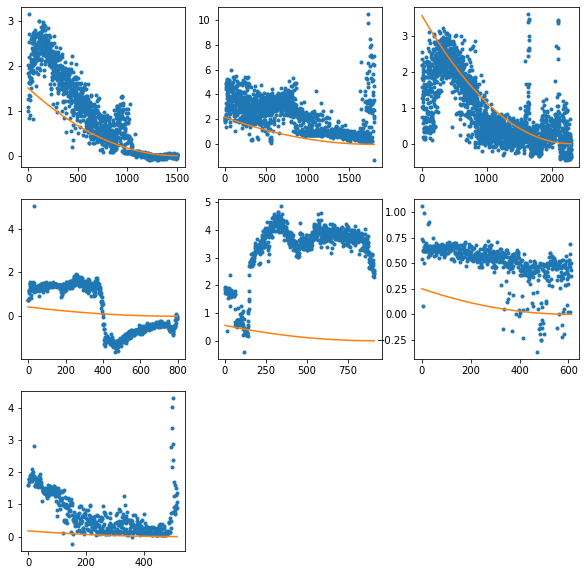

In [112]:
#pplot.plot(dd['target_predictions'].values[0])
#pplot.plot(dd['target_predictions'].values[9])
#pplot.plot(dd['target_predictions'].values[49])
dd = all_data[3][1]
#    X_target_experiments = X[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_data_target]]

#    eid_oh_target        = eid_oh[[i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_data_target]]
pplot.figure(figsize = (10,10))
for k, eid in enumerate(inds_data_target):
    ids_  = np.argmax(eid_oh_target,1) == eid
    pplot.subplot(3,3,k+1)
    #pplot.plot(yrem_norm_target[ids_], dd['target_predictions'].values[49][ids_],'.')
    pplot.plot(dd['target_predictions'].values[49][ids_],'.')
    pplot.plot(yrem_norm_target[ids_],'-')
    

In [89]:
inds_data_target

[1, 5, 16, 12, 13, 14, 3]

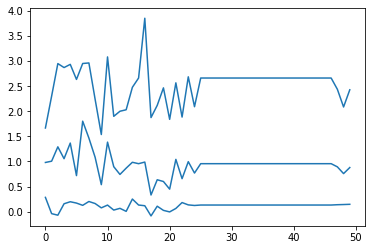

In [80]:
pplot.plot(np.quantile(np.hstack(dd['target_predictions'].values),0.1,0),'C0')
pplot.plot(np.quantile(np.hstack(dd['target_predictions'].values),0.5,0),'C0')
pplot.plot(np.quantile(np.hstack(dd['target_predictions'].values),0.9,0),'C0')